# Recurrent Neural Networks

All the models we have discussed so far were looking at the inputs as isolated instances. In image classification we determine the category of and image, in semantic segmentation we produce a semantic map from the input. But there are many cases were datapoints are not isolated instances and have connection to each other. Sequential data are the type of data where each instance is related to the instances came before. A good example for this type of data is time series data. At each point in time to the value of the time series depends on the value of the prior points. Recurrent Neural Networks (RNN) are a class of networks which deal with sequential data. There are many variants of Recurrent Neural Networks, including:

- Simple Recurrect Neural Networks (Simple RNN - or often just called RNN)
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In this notebook we will discuss LSTM; however, the general logic behind all these methods are the same. They only differ in the way they handel information internally. 
<img src='./images/RNN.png'>
<div style="font-size:70%">Recurrent Neural Networks Architecture - Credit to <a href='https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944'>Bao et al.</a></div>
At each step a set of values are stored as state of the model ($s$). The state is updated at each step and based on the value of the state the output of the model is calculated by passing state through the output layer ($V$). Also, the model takes an input $x_t$ and passes it through an input layer ($U$), The output of this layer is combined with the state of previous step and creates the new state ($s_t$). What is important here is that the input and output layers are the same for all the sequences of data. What makes the output different at each step are the input values and state of the model. <br>
Various architectures handel updating the state value differently and this is the main difference between Simple RNN, LSTM, and GRU. 

In [1]:
import torch
from torch import nn, optim
from torch import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# TODO use just seq(LSTM, linear)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        device = next(iter(self.parameters())).device
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n = h_n.view(-1, self.num_layers, self.hidden_size)[:, -1]
        out = self.linear(h_n)
        return out

## Classification
So far we tried single and multivariate time series using LSTM. But LSTMs are very flexible and useful for wide range of problems. For instance, we can have multi input and single output, or use a series to predict an entire different series. We can also use LSTM for classification of time series. What makes LSTM (or other types of Recurrecnt Neural Networks) interesting is that they are not just useful for time series. They can be used for any data that has sequence of values. For instance, they can be used for text prediction. If we map every word to a number then you can turn a text into a series of numbers then LSTM can be used for predicting the next word.


In this example we are going to look at well logs which are sequential data as well.

In [3]:
import pandas as pd

df = pd.read_parquet(
    "../../data/processed/geolink_norge_dataset/geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df['Well'] = df.index.get_level_values(0)
df['DEPT'] = df.index.get_level_values(1)
df.head()

LITHOLOGY_GEOLINK       CALI   RHOB         GR  \
Well    DEPT                                                         
15_9-12 2215.917725        Shaly Silt  14.438001  2.363  60.285748   
        2216.070068        Shaly Silt  14.633000  2.340  63.250000   
        2216.222412        Shaly Silt  14.813001  2.314  61.405998   
        2216.375000        Shaly Silt  14.383001  2.293  62.561596   
        2216.527344        Shaly Silt  14.202999  2.275  61.691055   

                            DTC      RDEP      RMED     Well         DEPT  
Well    DEPT                                                               
15_9-12 2215.917725  134.253601  0.737006  0.785088  15_9-12  2215.917725  
        2216.070068  129.101868  0.741000  0.840000  15_9-12  2216.070068  
        2216.222412  122.476944  0.752000  0.858000  15_9-12  2216.222412  
        2216.375000  116.908607  0.739962  0.857046  15_9-12  2216.375000  
        2216.527344  115.390953  0.715966  0.886082  15_9-12  2216.527344

In [4]:
# 29, 30, 31, 35 are valid groups
# c=df['Well'].value_counts()
# c[c>10000].sort_index()

In [5]:
# We  will stick to a gorup of long wells 29, 30, 31, 35 are valid groups
df=df[df['Well'].str.startswith('30')]
counts = df['Well'].value_counts()
counts[counts>0]

30_4-1      22921
30_7-7      18645
30_6-11     15591
30_2-1      15425
30_11-3     12813
30_3-2 R    10871
30_6-8      10792
30_6-5      10710
30_3-4 R    10457
30_3-3      10046
30_6-23      8101
30_6-14      6968
30_4-2       6927
30_3-5 S     4140
30_6-22      3580
Name: Well, dtype: int64

In [6]:
# Let take the top 12 lithologies, replacing the rest with "rare"
# print(len(df))
removed_labels = df["LITHOLOGY_GEOLINK"].value_counts()[12:].index
print(df['LITHOLOGY_GEOLINK'].value_counts())
print('removed_labels', removed_labels)
l = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
df['LITHOLOGY_GEOLINK']  = l.add_categories('rare').fillna('rare')
df['LITHOLOGY_GEOLINK'].value_counts()

Marlstone                 42085
Shaly Silt                42070
Silt                      37004
Argillaceous Limestone    12180
Cross Bedded Sst          10124
Silty Shale                7348
Silty Sand                 5605
Cinerite                   3808
Limestone                  3650
Sandstone                  1796
Calcareous Cement          1382
Coal                        935
Volcanic Tuff                 0
Carnallite                    0
Chalk                         0
Conglomerate                  0
Kaïnite                       0
Dolomite                      0
Gap                           0
Halite                        0
Metamorphic Rock              0
Plutonic Rock                 0
Polyhalite                    0
Porous Limestone              0
Sandy Silt                    0
Anhydrite                     0
Name: LITHOLOGY_GEOLINK, dtype: int64
removed_labels CategoricalIndex(['Volcanic Tuff', 'Carnallite', 'Chalk', 'Conglomerate',
                  'Kaïnite', 'Dolomite', 

Marlstone                 42085
Shaly Silt                42070
Silt                      37004
Argillaceous Limestone    12180
Cross Bedded Sst          10124
Silty Shale                7348
Silty Sand                 5605
Cinerite                   3808
Limestone                  3650
Sandstone                  1796
Calcareous Cement          1382
Coal                        935
rare                          0
Name: LITHOLOGY_GEOLINK, dtype: int64

In [7]:
removed_labels = list(df["LITHOLOGY_GEOLINK"].value_counts()[12:].keys())
i = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
i[i.isna()]

[], Categories (12, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale']

In [8]:
df["LITHOLOGY_GEOLINK"].values

['Silt', 'Silt', 'Silt', 'Silt', 'Silt', ..., 'Silt', 'Silt', 'Silt', 'Silt', 'Silt']
Length: 167987
Categories (13, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', ..., 'Silt', 'Silty Sand', 'Silty Shale', 'rare']

In [9]:
l = df['LITHOLOGY_GEOLINK']
l[l.isna()]

Series([], Name: LITHOLOGY_GEOLINK, dtype: category
Categories (13, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', ..., 'Silt', 'Silty Sand', 'Silty Shale', 'rare'])

In [10]:
# Remove unused categories, and order
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].values.remove_unused_categories()

# sort categories (leads to nicer histograms)
i = df['LITHOLOGY_GEOLINK'].values
litho_sorted = i.value_counts().sort_values(ascending=True).index
df['LITHOLOGY_GEOLINK'] = i.reorder_categories(list(litho_sorted), ordered=True)

df['LITHOLOGY_GEOLINK'].values.categories

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Limestone', 'Cinerite',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Silt', 'Shaly Silt', 'Marlstone'],
      dtype='object')

Marlstone                 42085
Shaly Silt                42070
Silt                      37004
Argillaceous Limestone    12180
Cross Bedded Sst          10124
Silty Shale                7348
Silty Sand                 5605
Cinerite                   3808
Limestone                  3650
Sandstone                  1796
Calcareous Cement          1382
Coal                        935
Name: LITHOLOGY_GEOLINK, dtype: int64

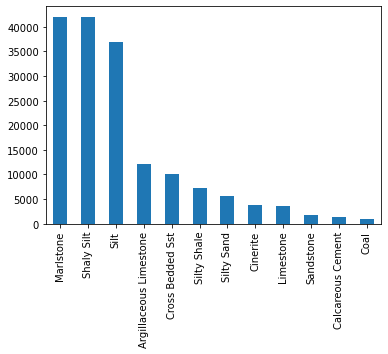

In [11]:
df['LITHOLOGY_GEOLINK'].value_counts().plot.bar()
df['LITHOLOGY_GEOLINK'].value_counts()

In [12]:
# Add a well int, so the model will know what well we use
well_index = df.index.get_level_values(0)
well_int = well_index.rename_categories(range(len(well_index.categories))).astype(int)
df['Well_int']= well_int
df[['Well_int']]

Well_int
Well    DEPT                 
30_11-3 2118.744629        83
        2118.896973        83
        2119.049561        83
        2119.201904        83
        2119.354248        83
...                       ...
30_7-7  5022.021484        99
        5022.173828        99
        5022.326660        99
        5022.479004        99
        5022.631348        99

[167987 rows x 1 columns]

1

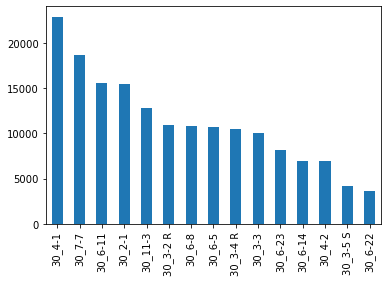

In [13]:
# Get a list of wells, ordered by frequency
well_counts = df['Well'].value_counts()
well_counts = well_counts[well_counts>0]
wells = list(well_counts.index)
well_counts.plot.bar()
1
# well_counts

In [14]:
# Select the N longest well logs
n_wells = min(len(wells), 10)
selected_wells = wells[:n_wells]
df = df.loc[selected_wells]
# df

In [15]:
df['LITH_ABV'] = df["LITHOLOGY_GEOLINK"].shift().fillna('Shaly Silt')
df['LITH_ABV_INT'] = df['LITH_ABV'].values.codes
df[['LITHOLOGY_GEOLINK', 'LITH_ABV']]

LITHOLOGY_GEOLINK          LITH_ABV
Well   DEPT                                           
30_4-1 1908.267822        Shaly Silt        Shaly Silt
       1908.420166        Shaly Silt        Shaly Silt
       1908.572510        Shaly Silt        Shaly Silt
       1908.724976        Shaly Silt        Shaly Silt
       1908.877319        Shaly Silt        Shaly Silt
...                              ...               ...
30_3-3 3414.269287  Cross Bedded Sst  Cross Bedded Sst
       3414.421387  Cross Bedded Sst  Cross Bedded Sst
       3414.573730  Cross Bedded Sst  Cross Bedded Sst
       3414.726074  Cross Bedded Sst  Cross Bedded Sst
       3414.878662  Cross Bedded Sst  Cross Bedded Sst

[138271 rows x 2 columns]

In [16]:
# SPLIT: We will train on measurements above Xkm depth, and test on deeper ones
from functools import partial

def get_depth_thresh(x, even_bottom=True):
    """
    On even number well codes take the bottom of the well for trainin
    """
    if len(x)==0: return x
    
    # if the well code is even take the top 
    code_is_even = (x['Well'].values.codes[0]%2)==0
    if code_is_even:
        even_bottom = not even_bottom
    
    d = x['DEPT']
    thresh = np.round(d.mean())
    x['thresh'] = thresh
    if even_bottom:
        return x[d>thresh]
    else:
        return x[d<thresh]


df_test = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=False))
df_train = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=True))
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (68626, 13) test (69643, 13)
Train 50%, test 50%


In [17]:
train = []
test = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    df_well.name = well
    i_halfway = int(len(df_well)*0.5)
    df_top = df_well.iloc[:i_halfway]
    df_bottom = df_well.iloc[i_halfway:]
    if i%2==0:
        train.append(df_top)
        test.append(df_bottom)
    else:
        train.append(df_bottom)
        test.append(df_top)
        
df_test = pd.concat(test).set_index(['Well', 'DEPT'], drop=False)
df_train = pd.concat(train).set_index(['Well', 'DEPT'], drop=False)
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (69135, 12) test (69136, 12)
Train 50%, test 50%


In [18]:
a=set(df_train.index)
b=set(df_test.index)
assert len(a.intersection(b))==0

We will be using depth and other measurements to determine the lithology. We dealt with the same problem in the tablular data. But in tabular data we only look at the measurements at each depth to find the class, while here we can look at the variations in the measurements as well.

And add depth as a feature column:

As usual we need to create a training and test set. here we will only use `15` wells for training and `15` for testing as using the entire dataset means we need to spend much longer time for training.

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn.

In [19]:
# # df['LITH_ID'] = encoder.transform(df.loc[:, "LITHOLOGY_GEOLINK"])
# # df['LITH_ID'] = encoder.transform(df.loc[:, "LITHOLOGY_GEOLINK"])
# df['LITH_ABV'] = df["LITHOLOGY_GEOLINK"].shift().fillna('Shaly Silt')
# df['LITH_ABV_INT'] = df['LITH_ABV'].values.codes
# df[['LITHOLOGY_GEOLINK', 'LITH_ABV']]

In [20]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

# Make a encoder, that order by frequency
encoder = LabelEncoder()

# TODO need to embed prev val..., one hot, then append
encoder.classes_ = df["LITHOLOGY_GEOLINK"].values.categories # np.array(counts.index.values)
print(encoder.classes_)
feat_cols = ["CALI", "RHOB", "GR", "DTC", "RDEP", "RMED", "DEPT", "Well_int", "LITH_ABV_INT"]
scaler.fit(df[feat_cols].values)

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Limestone', 'Cinerite',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Silt', 'Shaly Silt', 'Marlstone'],
      dtype='object')


StandardScaler()

`LabelEncoder` converts each type to a value.

In [21]:
encoder.transform(["Shaly Silt"])

array([5])

Now we can check the types at various depths:

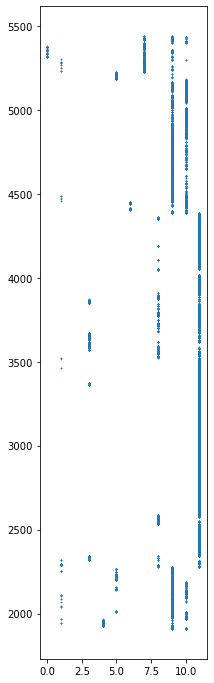

In [22]:
# TODO nice plot, vertical, facies colors
plt.figure(figsize=(3, 12))
idx = 0
x = df.loc[wells[idx], "DEPT"]
y = encoder.transform(df.loc[wells[idx], "LITHOLOGY_GEOLINK"])
plt.plot(y, x, '.', ms=1)

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.

Let's create training and test set, similar to what we had in multivariate time series. The only difference is here for each sequence of values we want the model to predict a value for each type.

In [23]:
seq_length = 10

x_train = []
y_train = []
features = scaler.transform(df_train.loc[:, feat_cols].values)
targets = encoder.transform(df_train.loc[:, "LITHOLOGY_GEOLINK"])

# # Add prev labels, as one hot, to inputs
# one_hot_targets = np.eye(len(encoder.classes_))[targets]
# prev_one_host_targets = np.roll(one_hot_targets, shift=1)
# features = np.concatenate([features, prev_one_host_targets], 1)

for i in range(len(targets) - seq_length):
    xi = features[i : i + seq_length, :]
    yi = targets[i + seq_length - 1]
    x_train.append(xi)
    y_train.append(yi)

x_test = []
y_test = []
features = scaler.transform(df_test.loc[:, feat_cols].values)
targets = encoder.transform(df_test.loc[:, "LITHOLOGY_GEOLINK"])

# # Add prev labels, as one hot, to inputs
# one_hot_targets = np.eye(len(encoder.classes_))[targets]
# prev_one_host_targets = np.roll(one_hot_targets, shift=1)
# features = np.concatenate([features, prev_one_host_targets], 1)

for i in range(len(targets) - seq_length):
    xi = features[i : i + seq_length, :]
    yi = targets[i + seq_length - 1]
    x_test.append(xi)
    y_test.append(yi)

In [24]:
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

It is important that we make sure the training and test set have close distribution. For instance, if there is a certain type in test data that doesn't exist in training data, the model will not be able to predict it.

In [25]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

def show_distribution(y):
    y = to_numpy(y)
    plt.hist(y, output_size * 2)
    plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=90)

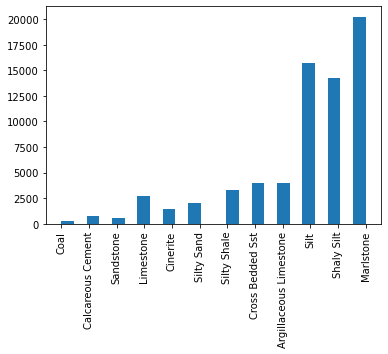

In [26]:
show_distribution(y_train)

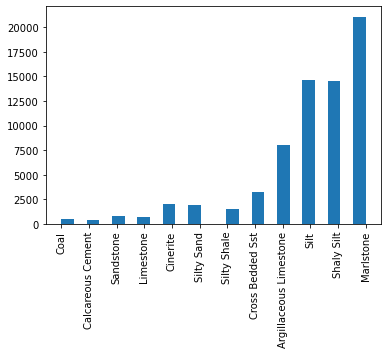

In [27]:
show_distribution(y_test)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x_train = torch.Tensor(x_train)#.to(device)
y_train = torch.LongTensor(y_train)#.to(device)
x_test = torch.Tensor(x_test)#.to(device)
y_test = torch.LongTensor(y_test)#.to(device)
x_train.shape, y_train.shape, x_test.shape, device

(torch.Size([69125, 10, 9]),
 torch.Size([69125]),
 torch.Size([69126, 10, 9]),
 'cuda')

We can still use the same class for the model. Here the input size is the number of features we are using to predict the type, and output size is the number of types. 

1

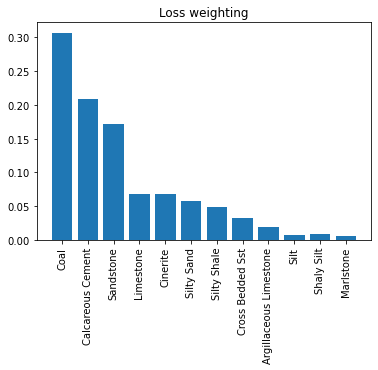

In [29]:
codes = df['LITHOLOGY_GEOLINK'].values.codes
unique, counts = np.unique(codes, return_counts=True)
weight = torch.from_numpy(1/(1e1+counts))
weight /= weight.sum()
# weight = None
weight

plt.title('Loss weighting')
# plt.bar(x=range(len(weight)), height=weight)
plt.bar(encoder.inverse_transform(unique), weight)
plt.xticks(rotation=90)
1

In [30]:
model = LSTM(
    input_size=x_train.shape[-1],
    hidden_size=32,
    num_layers=1,
    output_size=output_size,
)
model = model.to(device)
model

LSTM(
  (lstm): LSTM(9, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [31]:
# codes = df['LITHOLOGY_GEOLINK'].values.codes
# unique, counts = np.unique(codes, return_counts=True)
# weight = torch.from_numpy(1/(1e0+np.sqrt(counts)))
# weight /= weight.sum()
# weight

# plt.title('Loss weighting')
# # plt.bar(x=range(len(weight)), height=weight)
# plt.bar(encoder.inverse_transform(unique), weight)
# plt.xticks(rotation=90)
# 1

In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.nn.CrossEntropyLoss(weight=weight)
loss_func = torch.nn.CrossEntropyLoss()

In [33]:
from sklearn.metrics import accuracy_score, f1_score

In [34]:
score_fn=accuracy_score

def training_loop(epochs=1, bs=128):
    pbar1 = tqdm(total=epochs)
    pbar2 = tqdm(total=len(x_train) // bs)
    all_losses = []
    all_accuracys = []
    try:
        for epoch in range(epochs):
            model.train()
            training_loss = []
            training_accuracy = []
            pbar2.reset(len(x_train) // bs)
            for i in range(0, len(x_train), bs):
                optimizer.zero_grad()
                preds = model(x_train[i : i + bs, ...].to(device))
                loss = loss_func(preds, y_train[i : i + bs].to(device))
                loss.backward()
                optimizer.step()
                training_loss.append(loss.item())
                accuracy = score_fn(
                    to_numpy(y_train[i : i + bs]), to_numpy(preds).argmax(-1)
                )
                training_accuracy.append(accuracy)
                pbar2.update(1)
#                 print(
#                     f"Epoch {epoch+1}/{epochs}: Loss = {loss.item():.2f}, accuracy = {accuracy:.3f}",
#                     end="\r",
#                     flush=True,
#                 )

            print(
                f"Epoch {epoch+1}/{epochs}: Training Loss = {np.mean(training_loss):.2f}, accuracy = {np.mean(accuracy):.3f}"
            )

            model.eval()
            test_loss = []
            test_accuracy = []
            pbar2.reset(len(x_test) // bs)
            for i in range(0, len(x_test), bs):
                preds = model(x_test[i : i + bs, ...].to(device))
                loss = loss_func(preds, y_test[i : i + bs].to(device))
                test_loss.append(loss.item())
                accuracy = score_fn(
                    to_numpy(y_test[i : i + bs]), to_numpy(preds.argmax(-1))
                )
                test_accuracy.append(accuracy)
                pbar2.update(1)
            print(
                f"Epoch {epoch+1}/{epochs}: Test Loss = {np.mean(test_loss):.2f}, accuracy = {np.mean(test_accuracy):.3f}"
            )
            print("-" * 50)
            all_losses.append([np.mean(training_loss), np.mean(test_loss)])
            all_accuracys.append([np.mean(training_accuracy), np.mean(test_accuracy)])
            pbar1.update(1)
    except KeyboardInterrupt:
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    plt.figure()
    all_accuracys = np.array(all_accuracys)
    plt.plot(all_accuracys[:, 0], label="Training")
    plt.plot(all_accuracys[:, 1], label="Test")
    plt.title("accuracy")
    plt.legend()

In [35]:
preds = to_numpy(model(x_test.to(device)).argmax(axis=-1))
true = to_numpy(y_test)
score = score_fn(true, preds)
print(f'Random model acc {score:2.2%}')

Random model acc 1.12%


Let's train for 10 epochs

In [36]:
# Constant Baseline (most common in data)
common_train_value = pd.Series(to_numpy(y_train)).value_counts().index[0]
pred_baseline = np.ones(true.shape) * common_train_value
score=score_fn(true, pred_baseline)
print(f'acc {score:2.2%} for constant value')

# Prev litho Baseline
pred_baseline = np.roll(true, shift=1)
score=score_fn(true, pred_baseline)
print(f'acc {score:2.2%} for prev value')

acc 30.52% for constant value
acc 96.48% for prev value


In [37]:
from sklearn.dummy import DummyClassifier

for strategy in ["most_frequent", "stratified", "prior", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    score = dummy_clf.score(x_test, y_test)
    print(f"accuracy={score:2.2%} for {strategy}")

accuracy=30.52% for most_frequent
accuracy=19.53% for stratified
accuracy=30.52% for prior
accuracy=8.29% for uniform


Epoch 1/30: Training Loss = 1.69, accuracy = 1.000
Epoch 1/30: Test Loss = 1.31, accuracy = 0.522
--------------------------------------------------
Epoch 2/30: Training Loss = 1.05, accuracy = 1.000
Epoch 2/30: Test Loss = 1.37, accuracy = 0.366
--------------------------------------------------
Epoch 3/30: Training Loss = 0.84, accuracy = 1.000
Epoch 3/30: Test Loss = 1.23, accuracy = 0.525
--------------------------------------------------
Epoch 4/30: Training Loss = 0.65, accuracy = 1.000
Epoch 4/30: Test Loss = 0.88, accuracy = 0.678
--------------------------------------------------
Epoch 5/30: Training Loss = 0.53, accuracy = 1.000
Epoch 5/30: Test Loss = 0.61, accuracy = 0.777
--------------------------------------------------
Epoch 6/30: Training Loss = 0.44, accuracy = 1.000
Epoch 6/30: Test Loss = 0.48, accuracy = 0.858
--------------------------------------------------
Epoch 7/30: Training Loss = 0.39, accuracy = 1.000
Epoch 7/30: Test Loss = 0.41, accuracy = 0.883
--------

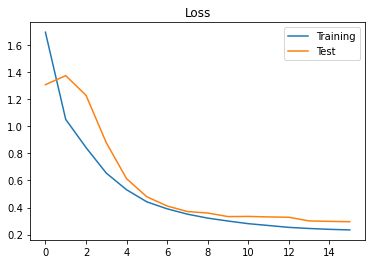

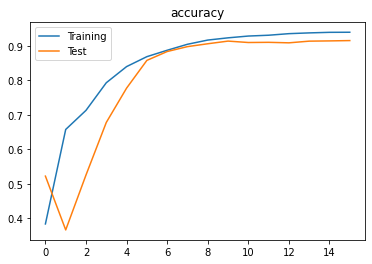

In [38]:
training_loop(30, 128)

In [39]:
preds = to_numpy(model(x_test.to(device)).argmax(axis=-1))
true = to_numpy(y_test)

In [40]:
# ours
print(score_fn(true,
    preds))

0.9281457049445939


1

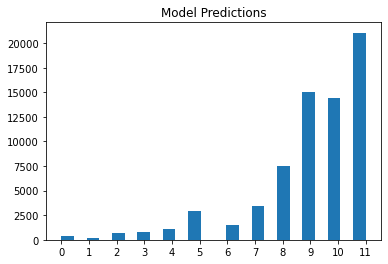

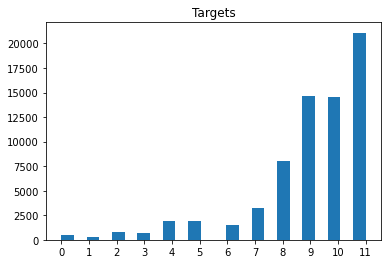

In [41]:
plt.hist(preds, bins=output_size * 2)
plt.title("Model Predictions")
plt.xticks(np.arange(output_size))
plt.figure()
plt.hist(true, bins=output_size * 2)
plt.title("Targets")
plt.xticks(np.arange(output_size))
1

In [42]:
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    return out_df

In [47]:
# df_report = classification_report(true, pred_baseline, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
# df_report

In [44]:
df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
df_report

,precision,recall,f1-score,support
Coal,0.83,0.63,0.72,449
Calcareous Cement,0.57,0.35,0.44,332
Sandstone,0.87,0.74,0.80,780
Limestone,0.76,0.96,0.85,672
Cinerite,0.88,0.49,0.63,1957
Silty Sand,0.59,0.89,0.71,1942
Silty Shale,0.91,0.90,0.90,1484
Cross Bedded Sst,0.83,0.89,0.86,3211
Argillaceous Limestone,0.98,0.92,0.95,8007
Silt,0.91,0.94,0.93,14638


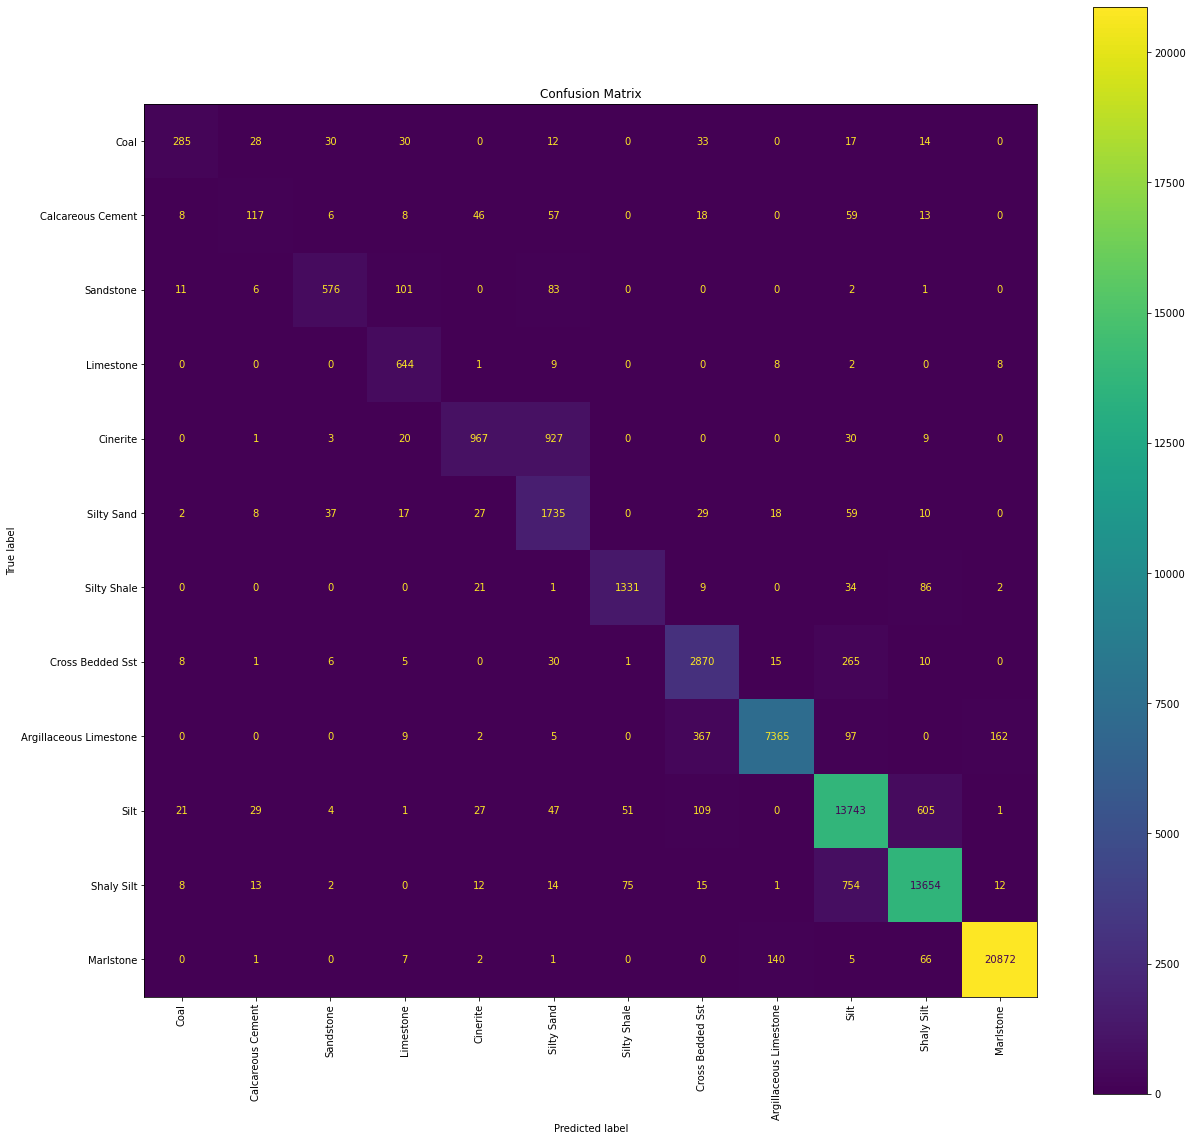

In [45]:
cm = sklearn.metrics.confusion_matrix(true, preds, labels=range(len(encoder.classes_)))

plt.figure(figsize=(20, 20))
plt.title('Confusion Matrix')
ax=plt.gca()
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.classes_)
disp.plot(ax=ax, xticks_rotation=90)
plt.show()

As we saw in the previous examples the model requires training over 100s of epochs to reach the best results. However, in this example due to large size of dataset and the model we stopped after `10` epochs. Try increasing the number of epochs to see how it will affect the accuracy.<br>

Obviously the model right now is not performing well. But there are number ways we can improve it:
1. Training for longer. instead of stopping after `10` epochs go for longer.
2. Increase the hidden state size.
3. Increase the size of training data by adding data from more wells to training. 
4. Increase the size of the sequences so the model get to look further in the history.

#### Exercise 2
Try one of the options above to improve the model.

In [46]:
# Code Here

Let's have a look at model's predictions.

The distribution of data shows that the model is too focused on type `17` and `18` which is why we are having low accuracy.


<div class="alert alert-success">
    
### Solutions  
<details><summary>See solutions</summary>

<details><summary>Exercise 1</summary>
<b>Increase sequence length to 18</b>

```Python
seq_length = 18
x, y = create_seq_data(data,seq_length)
xtrain = x[:100,:,:]
ytrain = y[:100,:]
xtest = x[100:,:,:]
ytest = y[100:,:]
model = LSTM(1, 50, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```
<b>Change model size to 100</b>
```Python
model = LSTM(1, 100, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```

</details>
<details><summary>Exercise 2</summary>
    <b>Larger hidden size</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=400,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(10, 1024)
```

<b>Train longer</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=200,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(20, 1024)
```
 
</details>
</details>
</div>

## Further Reading
- [Introduction to RNN](http://slazebni.cs.illinois.edu/spring17/lec02_rnn.pdf)
- [A friendly introduction to Recurrent Neural Networks](https://www.youtube.com/watch?v=UNmqTiOnRfg)
- [Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=97s)
- [Introduction to LSTM](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)
- [LSTM and GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Building RNN from scratch](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
